In [490]:
import numpy as np

import seaborn as sns
import pandas as pd
import os

os.chdir(os.path.expanduser('~/Documents/vivarium-ecoli'))

import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
from ecoli.processes.metabolism_redux import NetworkFlowModel, FlowResult, MetabolismRedux


FREE_RXNS = ["TRANS-RXN-145", "TRANS-RXN0-545", "TRANS-RXN0-474"]

sns.set(style='darkgrid', palette='viridis', context='talk')


# Import simulation output

Before running this, I ran a sim in ecoli/experiments/metabolism_redux_sim.py with -n 2 to generate a simulation output. This is necessary to replicate the simulation environment, where we e.g. have dynamic demand for amino acids and nucleotides, and varying cell volumes.

You don't have to do this for now. We'll use a single time step from the simulation output to test the network flow model on its own.

In [491]:
time = '50'
date = '2023-06-26'
experiment = 'fba-redux'
entry = f'{experiment}_{time}_{date}'
folder = f'out/fbagd/{entry}/'

In [492]:
output = np.load(folder + 'output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [493]:
# this is the model itself - we'll pull e.g. stoichiometry from here.
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

metabolism = agent['ecoli-metabolism-redux']
stoichiometry = metabolism.stoichiometry

In [494]:
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).loc[24, :]
maintenance = pd.DataFrame(fba["maintenance_target"][1:], columns=['maintenance_reaction']).iat[24, 0]
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).loc[24, :]

## Connect to EcoCyc to go from Genes -> Reactions

We use the EcoCyc API to automatically figure out what are made possible by the genes we are adding. While reactions are always possible, enzymes make them faster to the point that it is useful to the cell.

In [495]:
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'Cellman0451'})

<Response [200]>

In [496]:
added_gene_to_reaction = {"EG10941": "putative-L-selenocysteine-synthesis",
                          "G7325": "cysteine-desulfurase-FeS-cluster-assembly",
                          "EG12132": "iron-transport-FeS-cluster-assembly",
                          "G7324": "complex-formation-FeS-cluster-assembly",
                          "EG12130": "cluster-transport-FeS-cluster-assembly"
                          # Missing HscB with HscA complex
                          }

In [497]:
condition_df = pd.read_excel("notebooks/new_environments/temp.xlsx")
condition_df["Genes"] = condition_df["Genes"].apply(lambda x: set(x.split(", ") if x == x else set()))
condition_df["Add"] = condition_df["Add"].apply(lambda x: set(str(x).split(", ") if x == x else set()))
condition_df["Remove"] = condition_df["Remove"].apply(lambda x: set(str(x).split(", ") if x == x else set()))
condition_df["Demand"] = condition_df["Demand"].apply(lambda x: set(str(x).split(", ") if x == x else set()))
condition_df["Reactions"] = [[np.nan]] * len(condition_df)
condition_df["Substrates"] = [[np.nan]] * len(condition_df)

condition_df

,Environment,Genes,Add,Remove,Demand,Reactions,Substrates
0,Testing L-Selenocysteine,{EG10941},"{SER[c], SEPO3[c]}",{},{L-SELENOCYSTEINE[c]},[nan],[nan]
1,Testing Fe-S Clusters,"{EG12132, EG12130, G7325, G7324}","{CYS[c], FE+2[c]}",{},{DISORDERED-FdS-IscU[c]},[nan],[nan]
2,Vitamin B Uptake,"{EG10126, EG10130, EG10127, EG10128}",{COB-I-ALAMIN[p]},{},{COB-I-ALAMIN[c]},[nan],[nan]


In [498]:
length = len(condition_df.index)

for i in range(length):
    genes = condition_df.loc[i, "Genes"]
    rxn_set = set()
    added_rxn_set = set()

    for gene in genes:
        function = "reactions-of-gene"
        name = gene
        req_str = f"https://websvc.biocyc.org/apixml?fn={function}&id=ECOLI:{name}&detail=none&fmt=json"

        r = s.get(req_str)
        if gene in added_gene_to_reaction.keys():
            added_rxn_set.add(added_gene_to_reaction[gene])
        else:
            o = xmltodict.parse(r.content)['ptools-xml']['Reaction']
            if type(o) is dict:
                o = [o]

            for rxn in o:
                if type(rxn) is not str: # no rxns
                    rxn_set.add(rxn['@frameid'])
                else:
                    print(gene, rxn)



    overall_list = []
    for reaction in rxn_set:
        compound_set = set()
        function = "substrates-of-reaction"
        name = reaction
        req_str = f"https://websvc.biocyc.org/apixml?fn={function}&id=ECOLI:{name}&detail=none&fmt=json"

        r = s.get(req_str)
        o = xmltodict.parse(r.content)['ptools-xml']['Compound']
        if type(o) is dict:
            o = [o]

        for compound in o:
            if type(compound) is not str:
                compound_set.add(compound['@frameid'])
            else:
                print(reaction, compound)

        overall_list.append(compound_set)

    condition_df.at[i, "Reactions"] = rxn_set | added_rxn_set
    # condition_df.at[i, "Reactions"].update(added_rxn_set)
    condition_df.at[i, "Substrates"] = overall_list
    condition_df.loc[i + length] = [condition_df.at[i, "Environment"] + " CONTROL", set(), set(), set(), set(), condition_df.at[i, "Reactions"], []]
    # This is to create the control

In [499]:
condition_df

,Environment,Genes,Add,Remove,Demand,Reactions,Substrates
0,Testing L-Selenocysteine,{EG10941},"{SER[c], SEPO3[c]}",{},{L-SELENOCYSTEINE[c]},{putative-L-selenocysteine-synthesis},[]
1,Testing Fe-S Clusters,"{EG12132, EG12130, G7325, G7324}","{CYS[c], FE+2[c]}",{},{DISORDERED-FdS-IscU[c]},"{iron-transport-FeS-cluster-assembly, complex-...",[]
2,Vitamin B Uptake,"{EG10126, EG10130, EG10127, EG10128}",{COB-I-ALAMIN[p]},{},{COB-I-ALAMIN[c]},"{BTUR2-RXN, RXN-19342, RXN0-1565, COBALADENOSY...","[{ADENOSYLCOBINAMIDE, P3I, CPD-20903, ATP}, {C..."
3,Testing L-Selenocysteine CONTROL,{},{},{},{},{putative-L-selenocysteine-synthesis},[]
4,Testing Fe-S Clusters CONTROL,{},{},{},{},"{iron-transport-FeS-cluster-assembly, complex-...",[]
5,Vitamin B Uptake CONTROL,{},{},{},{},"{BTUR2-RXN, RXN-19342, RXN0-1565, COBALADENOSY...",[]


## Quick and dirty but workhorse loop (after init)

In [500]:
results_df = pd.DataFrame(columns=["Environment", "Reaction", "Flux"])
zero_df = pd.DataFrame()
all_flux = []

reactions_add = {"putative-L-selenocysteine-synthesis": {'SEPO3[c]': -1, 'SER[c]': -1, 'Pi[c]': 1, 'L-SELENOCYSTEINE[c]': 1},
                 "cysteine-desulfurase-FeS-cluster-assembly": {'CYS[c]': -1, 'L-ALPHA-ALANINE[c]': 1, 'S-SULFANYL-IscS[c]': 1},
                 "iron-transport-FeS-cluster-assembly": {'FE+2[c]': -1, 'DISORDERED-FdS-IscU[c]': 1},
                 "complex-formation-FeS-cluster-assembly": {'DISORDERED-FdS-IscU[c]': -1, 'S-SULFANYL-IscS[c]': -1, 'S-SULFANYL-DISORDERED-FdS-IscU[c]': 1},
                 "cluster-transport-FeS-cluster-assembly": {'S-SULFANYL-DISORDERED-FdS-IscU[c]': -1, 'ATP[c]': -1, 'ADP[c]': 1, 'CPD-6[c]': 1}
                 # Insert other added reactions here
                 }

metabolites_add = ['S-SULFANYL-IscS[c]', 'DISORDERED-FdS-IscU[c]', 'S-SULFANYL-DISORDERED-FdS-IscU[c]', 'CPD-6[c]']

catalyst_add = {"putative-L-selenocysteine-synthesis": 'CPLX0-1141[c]',
                "cysteine-desulfurase-FeS-cluster-assembly": 'G7325-MONOMER[c]',
                "iron-transport-FeS-cluster-assembly": 'EG12132-MONOMER[c]',
                "complex-formation-FeS-cluster-assembly": 'G7324-MONOMER[c]',
                "cluster-transport-FeS-cluster-assembly": 'HSC-Complex[c]'}

for j in range(len(condition_df)):
    metabolites_idx = {species: i for i, species in enumerate(metabolism.metabolite_names)}
    reaction_catalysts = metabolism.parameters['reaction_catalysts']
    metabolism.catalyst_ids = metabolism.parameters['catalyst_ids']
    catalyst_idx = {catalyst: i for i, catalyst in enumerate(metabolism.catalyst_ids)}

    new_stoich = metabolism.stoichiometry.copy()
    new_metabolites = metabolism.metabolite_names.copy()
    new_reaction_names = metabolism.reaction_names.copy()

    condition_idx = j

    uptake = metabolism.allowed_exchange_uptake

    homeostatic = dict(pd.DataFrame(fba["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).loc[24, :])
    new_demand = condition_df.at[condition_idx, "Demand"]
    if new_demand != set():
        for met in new_demand:
            homeostatic[met] = 0
            flat_demand_add = 100
            if met not in metabolites_add:
                function = "reactions-of-compound"
                name = met[:-3]
                req_str = f"https://websvc.biocyc.org/apixml?fn={function}&id=ECOLI:{name}&detail=none&fmt=json"

                r = s.get(req_str)
                o = xmltodict.parse(r.content)['ptools-xml']['Reaction']
                if type(o) is dict:
                    o = [o]
                for rxn in o:
                    if type(rxn) is not str: # no rxns
                        function = "substrates-of-reaction"
                        req_str = f"https://websvc.biocyc.org/getxml?id=ECOLI:{rxn['@frameid']}&detail=low"
                        r = s.get(req_str)
                        left = xmltodict.parse(r.content)['ptools-xml']['Reaction']['left']
                        right = xmltodict.parse(r.content)['ptools-xml']['Reaction']['right']
                        if type(left) is dict:
                            left = [left]
                        if type(right) is dict:
                            right = [right]
                        for compound in left:
                            if type(compound) is not str:
                                try:
                                    if compound['Compound']['@frameid'] == name:
                                        for demand_compound in right:
                                            try:
                                                if type(demand_compound) is not str and demand_compound['Compound']['@frameid'] in homeostatic:
                                                    homeostatic[met] += homeostatic[demand_compound['Compound']['@frameid']]
                                            except KeyError:
                                                if type(demand_compound) is not str and demand_compound['Protein']['@frameid'] in homeostatic:
                                                    homeostatic[met] += homeostatic[demand_compound['Protein']['@frameid']]
                                except KeyError:
                                    if compound['Protein']['@frameid'] == name:
                                        for demand_compound in right:
                                            if type(demand_compound) is not str and demand_compound['Compound']['@frameid'] in homeostatic:
                                                homeostatic[met] += homeostatic[demand_compound['Compound']['@frameid']]
                                finally:
                                    pass

            homeostatic[met] += flat_demand_add
            # Maybe look at what the demanded metabolite goes into and use that quantity + a flat value

    uptake = set(uptake)

    addition = condition_df.at[condition_idx, "Add"]
    removals = condition_df.at[condition_idx, "Remove"]

    uptake = uptake | addition
    uptake = uptake - removals

    for reaction in condition_df.at[condition_idx, "Reactions"]:
        if reaction in catalyst_add:
            catalyst_idx[catalyst_add[reaction]] = len(catalyst_idx)

        if reaction in reactions_add:
            for metabolite in reactions_add[reaction]:
                if metabolite in metabolites_add:
                    new_row = np.zeros([1, np.shape(new_stoich)[1]])
                    new_stoich = np.append(new_stoich, new_row, axis=0)
                    new_metabolites.append(metabolite)
                    metabolites_idx[metabolite] = len(metabolites_idx)

            new_reaction_names.append(reaction)
            new_col = np.zeros([len(new_stoich), 1])
            new_stoich = np.append(new_stoich, new_col, axis=1)

            for species, coefficient in reactions_add[reaction].items():
                i = metabolites_idx[species]
                new_stoich[i, np.shape(new_stoich)[1] - 1] = coefficient

            # now adds an entry for every reaction, list can be empty
            reaction_catalysts[reaction] = [catalyst_add[reaction]]
            # Taken from reconstruction/ecoli.../complexation reactions to find the complex that the gene forms
            enzyme_idx = [catalyst_idx[catalyst] for catalyst in reaction_catalysts.get(reaction, [])]
            metabolism.catalyzed_rxn_enzymes_idx.append(enzyme_idx)

    model = NetworkFlowModel(
            stoich_arr=new_stoich,
            metabolites=new_metabolites,
            reactions=new_reaction_names,
            homeostatic_metabolites=list(dict(homeostatic).keys()),
            kinetic_reactions=list(dict(kinetic).keys()),
            free_reactions=FREE_RXNS)
    model.set_up_exchanges(exchanges=metabolism.exchange_molecules, uptakes=uptake)

    objective_weights = {'secretion': 0.01, 'efficiency': 0.0001, 'kinetics': 0.000001}
    solution: FlowResult = model.solve(
                homeostatic_targets=np.array(list(dict(homeostatic).values())),
                maintenance_target=maintenance,
                kinetic_targets=np.array(list(dict(kinetic).values())),
                binary_kinetic_idx=[],
                objective_weights=objective_weights,
                upper_flux_bound=100000000)

    # Check flux
    fluxes = pd.Series(solution.velocities, index=new_reaction_names)
    # fluxes = pd.DataFrame({model.rxns[i]: [solution.velocities[model.rxns[i]]] for i in range(len(model.rxns))}).T
    fluxes.columns = ["Flux"]
    all_flux.append(fluxes)

    if condition_df.at[condition_idx, "Environment"][-7:] == "CONTROL":
        control_df = pd.DataFrame()
        flux_threshold = 100
        for j, k in enumerate(fluxes.index):
            if abs(all_flux[condition_idx - length][k] - fluxes[k]) / abs(fluxes[k] + 0.01) >= flux_threshold:
                control_df = control_df.append(pd.DataFrame([[condition_df.at[condition_idx, "Environment"],
                          fluxes.index[j],
                         (all_flux[condition_idx - length][k] - fluxes[k]) / (fluxes[k] + 0.01) ]], columns=["Environment", "Reaction", "(Experiment - Control)/(Control + 0.01) Flux"]))
        if len(control_df) > 0:
            control_df = control_df.sort_values(by=["(Experiment - Control)/(Control + 0.01) Flux"], ascending=False)
        control_df.to_csv(rf'notebooks/new_environments/figures/control_differences/{condition_df.at[condition_idx, "Environment"]}.csv')
    else:
        relevant_rxns = condition_df.at[condition_idx, "Reactions"]
        relevant_rxn_idx = []

        for rxn in relevant_rxns:
            relevant_rxn_idx.extend(list(np.where(fluxes.index.str.contains(rxn))[0] ))

        relevant_fluxes = fluxes.iloc[relevant_rxn_idx]

        relevant_nonzero_fluxes = relevant_fluxes[relevant_fluxes != 0]
        zero_fluxes = relevant_fluxes[relevant_fluxes == 0]

        for j, k in enumerate(relevant_nonzero_fluxes.index):
            results_df = results_df.append(pd.DataFrame([[condition_df.at[condition_idx, "Environment"],
                          relevant_nonzero_fluxes.index[j],
                          relevant_nonzero_fluxes[k]]], columns=["Environment", "Reaction", "Flux"]))

        for j, k in enumerate(zero_fluxes.index):
            zero_df = zero_df.append(pd.DataFrame([[condition_df.at[condition_idx, "Environment"],
                          zero_fluxes.index[j],
                          zero_fluxes[k]]], columns=["Environment", "Reaction", "Flux"]))

    print(f"""Finished {condition_df.at[condition_idx, "Environment"]}""")
zero_df.to_csv(r'notebooks/new_environments/figures/zero_flux.csv')

100
Finished Testing L-Selenocysteine
100
Finished Testing Fe-S Clusters
100
Finished Vitamin B Uptake
Finished Testing L-Selenocysteine CONTROL
Finished Testing Fe-S Clusters CONTROL
Finished Vitamin B Uptake CONTROL


In [501]:
# results_df["Reaction"] = results_df['Reaction'].str.slice(0,20)
results_df["log(Flux)"] = np.log10(results_df["Flux"])
results_df

,Environment,Reaction,Flux,log(Flux)
0,Testing L-Selenocysteine,putative-L-selenocysteine-synthesis,100.0,2.000000
0,Testing Fe-S Clusters,cysteine-desulfurase-FeS-cluster-assembly,771039.0,5.887076
0,Vitamin B Uptake,ABC-5-RXN,100.0,2.000000


In [502]:
# for each environment, plot the fluxes of the reactions that are relevant to that environment.
# g = sns.catplot(y="Environment",hue="Reaction", x="log(Flux)", data=results_df, kind="bar", aspect=2, height=10, sharey=False)
# g.savefig("notebooks/new_environments/figures/rxns_light_up.pdf")

In [503]:
import textwrap

def wrap_x_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

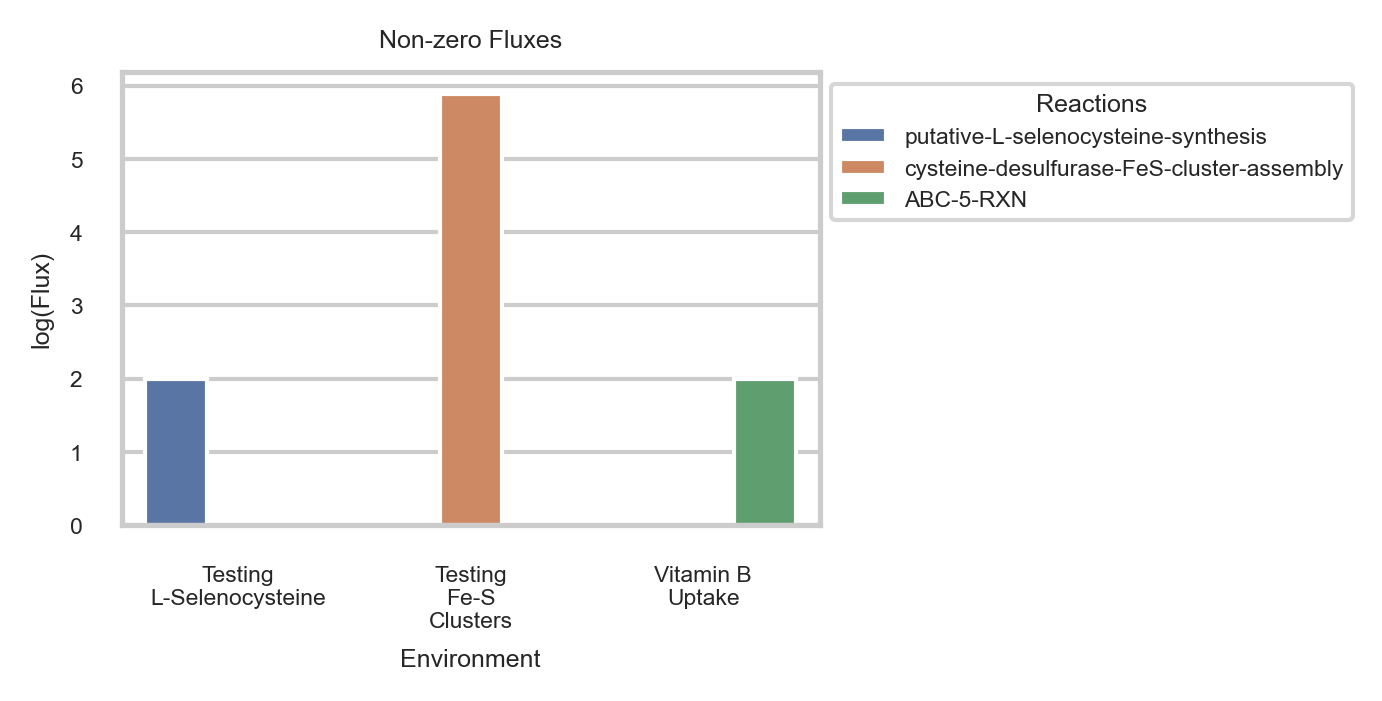

In [504]:
sns.set_theme(style="whitegrid", rc={'figure.dpi': 300}, font_scale=0.5)
fig, ax = plt.subplots(figsize=(len(results_df["Environment"].unique()), 2))
ax.set_title("Non-zero Fluxes")
ax = sns.barplot(data=results_df, x="Environment", y="log(Flux)", ax=ax, hue="Reaction")
ax.legend(bbox_to_anchor=(1, 1), title='Reactions', loc='upper left', ncol = 1)
wrap_x_labels(ax, 10)
fig = ax.get_figure()
plt.show(fig)
fig.savefig("notebooks/new_environments/figures/vert_bar_rxns.png")